# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [30]:
import cv2 as cv
import numpy as np

In [37]:
titles = ['Original MRI brain image', 'MRI brain image after the median filter', 'MRI brain image after the histogram equalization']
len(titles)
for i in range(1,len(titles)):
    print(i)

1
2


In [31]:
import tarfile
import os
#data_base_path = os.path.join(os.pardir, 'data')
data_base_path = os.path.join('/home/my_notebooks/iapr', 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

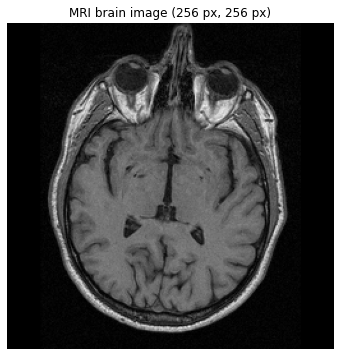

In [32]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### Image Pre-processing

Before we apply different algorithms to implement image segmentation, multiple pre-processing steps are used to improve the quality of the image so that we can analyse it in a better way. In this part, our goal is to suppress undesired noise/distortions in image and enhance some features, which makes it easier to segment the brain from background and skull without losing too much useful information. 

In this part, both libraries like opencv and sklearn will be used

Firstly, we plot the histogram of this image to check the distribution of pixels

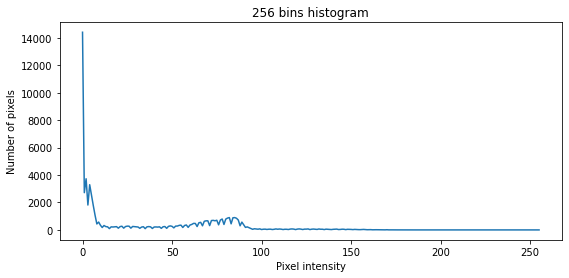

In [74]:
# plot the histogram of image
hist_brain_im = cv.calcHist([brain_im],[0],None,[256],[0,256])
plt.figure(figsize=(9, 4))
plt.plot(hist_brain_im)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')
plt.show()

As the histogram shows, two main peaks can be identified.
1. The 1st peak around 0 mainly corresponds to the dark backgound. 
2. The 2d peak around 75 mainly corresponds to the foreground object, the brain. 
3. As our goal is to extract the brain, those pixels between 50 and 100 (brain mixed with skull) will be mainly focused.


In [64]:
def plotMultipleImages(nrows, ncols, images, titles):
    fig = plt.figure(figsize=(10,7))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    for i in range(len(titles)):
        ax = fig.add_subplot(nrows, ncols, i+1)
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
    plt.show()

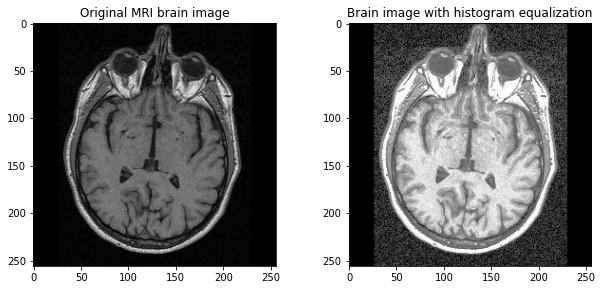

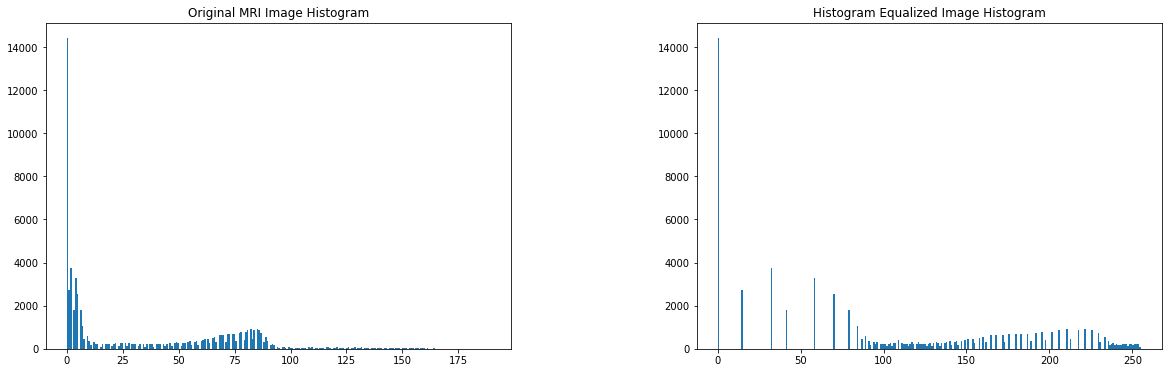

In [79]:
# histogram equalizer
equ_brain_im = cv.equalizeHist(brain_im)
hist_equal_brain_im = cv.calcHist([equ_brain_im],[0],None,[256],[0,256])

titles = ['Original MRI brain image', 'Brain image with histogram equalization']
images = [brain_im, equ_brain_im]
plotMultipleImages(1, 2, images, titles)

titles = ['Original MRI Image Histogram', 'Histogram Equalized Image Histogram']
images = [brain_im, equ_brain_im]
fig = plt.figure(figsize=(20,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.hist(outputs[i-1].ravel(), bins=256)
    plt.title(titles[i-1])
plt.show()

### 1.2 Region growing (5pts)

In [3]:
# Add your implementation and discussion
titles = ['Original MRI brain image', 'MRI brain image after the median filter', 'MRI brain image after the histogram equalization']
outputs = [brain_im, brain_im_medfil, brain_im_eqhist]

### 1.3 Contour detection (5pts)

In [4]:
# Add your implementation and discussion

### 1.4 Additional method (5pts)

In [5]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [6]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


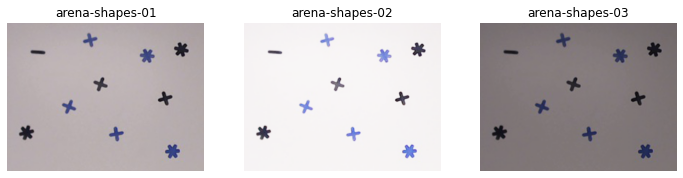

In [7]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [8]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [9]:
# Add your implementation and discussion